In [1]:
import torch
import malt

dummy_targets = torch.Tensor([0.0])

regressor = malt.models.regressor.GPyTorchExactRegressor(
    dummy_targets,
    in_features=128,
    out_features=2,
)

Using backend: pytorch


In [2]:
import torch
import dgl
import malt

dummy_targets = torch.Tensor([0.0])

net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128
    ),
    regressor=malt.models.regressor.GPyTorchExactRegressor(
        dummy_targets,
        in_features=128,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

point = malt.Molecule("C")
point.featurize()
graph = dgl.batch([point.g])

y = net.condition(graph)
assert y.mean.item() == 0.0

In [3]:
import torch
import dgl
import malt
import gpytorch

dummy_targets = torch.tensor([[4.0]])

net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32
    ),
    regressor=malt.models.regressor.GPyTorchExactRegressor(
        dummy_targets,
        in_features=32,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

point = malt.Molecule("CCCCCCC")
point.featurize()
graph = dgl.batch([point.g])

mll = gpytorch.mlls.ExactMarginalLogLikelihood(net.regressor.likelihood, net)

net.train()
y_pred = net(graph)
loss = mll(y_pred, torch.tensor([[2.0]]))
loss.backward()

net.eval()
y = net(graph)
assert y.mean.item() != 0.0

In [5]:
import torch
import dgl
import malt

dataset = malt.data.collections.linear_alkanes(10)
dataset_loader = dataset.view(batch_size=len(dataset))
g, y = next(iter(dataset_loader))

net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128
    ),
    regressor=malt.models.regressor.GPyTorchExactRegressor(
        y,
        in_features=128,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

if torch.cuda.is_available():
    net.cuda()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(net.regressor.likelihood, net)

net.train()
y_pred = net(g)
loss = mll(y_pred, y).mean()
loss.backward()

net.eval()
y_hat = net(g)
assert y_hat.mean.shape[0] == 10
assert len(y_hat.mean.shape) == 1

In [13]:
import malt
import torch
from malt.agents.player import SequentialModelBasedPlayer

dataset = malt.data.collections.linear_alkanes(10)
g, y = dataset.batch()
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
   representation=malt.models.representation.DGLRepresentation(
       out_features=32
   ),
   regressor=malt.models.regressor.ExactGaussianProcessRegressor(
       y, in_features=32, out_features=2,
   ),
   likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)
if torch.cuda.is_available():
    model.cuda()
    
mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
    model.regressor.likelihood,
    model
)

player = SequentialModelBasedPlayer(
    model = model,
    policy=malt.policy.Greedy(),
    trainer=malt.trainer.get_default_trainer(),
    marginal_likelihood=mll,
    merchant=malt.agents.merchant.DatasetMerchant(dataset),
    assayer=malt.agents.assayer.DatasetAssayer(dataset),
)

while True:
    if player.step() is None:
        break

In [40]:
import torch
import dgl
import malt

dataset = malt.data.collections.linear_alkanes(10)
dataset_loader = dataset.view(batch_size=len(dataset))
g, y = next(iter(dataset_loader))
y = y.reshape(-1, 1)


net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128
    ),
    regressor=malt.models.regressor.HardcodedExactGaussianProcessRegressor(
        y,
        in_features=128,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

if torch.cuda.is_available():
    net.cuda()


mll = malt.models.marginal_likelihood.HardcodedExactMarginalLogLikelihood(
    net.likelihood, net
)

net.train()
y_hat = net(g)
loss = mll(y_hat, y)
loss.backward()

y_hat = net.condition(g)
assert y_hat.mean.shape[0] == 10
assert len(y_hat.mean.shape) == 1

In [41]:
dataset = malt.data.collections.esol()
dataset.shuffle()
ds_tr, ds_te = dataset[:800], dataset[800:]

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [47]:
g, y = ds_tr.batch()

net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=60
    ),
    regressor=malt.models.regressor.HardcodedExactGaussianProcessRegressor(
        y,
        in_features=60,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

if torch.cuda.is_available():
    net.cuda()


mll = malt.models.marginal_likelihood.HardcodedExactMarginalLogLikelihood(
    net.likelihood, net
)

y_hat = net(g)
loss = mll(y_hat, y)
loss.backward()

y_hat = net.condition(g)

g, y = ds_te.batch()

net.eval()
with torch.no_grad():
    net(g)

In [33]:
# g, y = next(iter(dataset[:4].view(batch_size=4)))
# net(g)

In [14]:
import torch
import dgl
import malt

dummy_targets = torch.Tensor([4.0]*9)

net = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128
    ),
    regressor=malt.models.regressor.HardcodedExactGaussianProcessRegressor(
        dummy_targets,
        in_features=128,
        out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

point = malt.Molecule("C")
point.featurize()
graph = dgl.batch([point.g, point.g])

mll = malt.models.marginal_likelihood.HardcodedExactMarginalLogLikelihood(
    net.likelihood, net
)

net.train()
y_hat = net(graph)
loss = mll(y_hat, torch.tensor([[5.0, 5.0]]))
loss.backward()

net.eval()
y = net.condition(graph)
assert y.mean.item() != 0.0

RuntimeError: Incompatible matrix sizes for triangular_solve: each A matrix is 2 by 2 but each b matrix is 9 by 1

In [12]:
net.condition(graph)

MultivariateNormal(loc: tensor([3.8103], grad_fn=<ExpandBackward0>), covariance_matrix: tensor([[0.0474]], grad_fn=<ExpandBackward0>))

In [11]:
%load_ext autoreload
%autoreload 2

import malt
import torch
from malt.agents.player import SequentialModelBasedPlayer

dataset = malt.data.collections.linear_alkanes(10)
g, y = dataset.batch()
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
   representation=malt.models.representation.DGLRepresentation(
       out_features=32
   ),
   regressor=malt.models.regressor.ExactGaussianProcessRegressor(
       y, in_features=32, out_features=2,
   ),
   likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)
if torch.cuda.is_available():
    model.cuda()

mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
    model.regressor.likelihood,
    model
)

player = SequentialModelBasedPlayer(
    model = model,
    policy=malt.policy.Greedy(),
    trainer=malt.trainer.get_default_trainer(),
    marginal_likelihood=mll,
    merchant=malt.agents.merchant.DatasetMerchant(dataset),
    assayer=malt.agents.assayer.DatasetAssayer(dataset),
)

while True:
    if player.step() is None:
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
g, y = ds.batch(by=['g', 'y'])
torch.nn.functional.mse_loss(DumbModel(input_)(g).mean, target)

tensor(1.2900)

In [37]:
class DumbModel(object):
    def __init__(self, y):
        self.y = y

    def __call__(self, *args, **kwargs):
        return torch.distributions.Normal(
            self.y.ravel().cuda(), 1.0
        )

import torch
import malt
from malt.metrics.supervised_metrics import MSE, MAPE, RMSE, R2
from malt.metrics.base_metrics import mse, mape, rmse, r2
input_ = torch.randn(5, 1)
target = torch.randn(5, 1)

ds = malt.Dataset()

for idx in range(5):
    point = malt.Molecule(smiles="C", metadata={'y': target[idx].item()})
    ds.append(point)

assert MSE()(DumbModel(input_), ds) == mse(input_, target)
assert MAPE()(DumbModel(input_), ds) == mape(input_, target)
assert RMSE()(DumbModel(input_), ds) == rmse(input_, target)
assert R2()(DumbModel(input_), ds) == r2(input_, target)

c:\users\micha\dev\choderalab\malt\malt\metrics\base_metrics.py:4: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(target, input)


RuntimeError: The size of tensor a (20) must match the size of tensor b (5) at non-singleton dimension 0

In [30]:
ds_te = ds
g, y = ds_te.batch(by=['g', 'y'])
with torch.no_grad():
    y_hat = model(g).mean

getattr(malt.metrics.base_metrics, 'mse')(y_hat, y)

tensor(2.3256, device='cuda:0', grad_fn=<MseLossBackward0>)

In [16]:
mse(input_, target)

tensor(1.6681)

In [15]:
MSE()(DumbModel(input_), ds)

tensor(1.6681, device='cuda:0')

In [ ]:
g, y = ds.batch(by=['g', 'y'])
y_hat = DumbModel(input_)(g).mean
malt.metrics.base_metrics.mse(y_hat, target)

In [12]:
MSE()(DumbModel(input_), ds)

tensor(1.8533, device='cuda:0')

In [5]:
mse(input_, target)

tensor(1.6798)

In [48]:
%load_ext autoreload
%autoreload 2

import malt
import torch
from malt.agents.player import SequentialModelBasedPlayer

dataset = malt.data.collections.linear_alkanes(10)
# dataset = malt.data.collections.esol()[:100]

g, y = dataset.batch()
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
   representation=malt.models.representation.DGLRepresentation(
       out_features=128
   ),
   regressor=malt.models.regressor.HardcodedExactGaussianProcessRegressor(
       y, in_features=128, out_features=2,
   ),
   likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)

if torch.cuda.is_available():
    model.cuda()

mll = malt.models.marginal_likelihood.HardcodedExactMarginalLogLikelihood(
    model.likelihood, model
)

# mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
#     model.regressor.likelihood, model
# )

player = SequentialModelBasedPlayer(
   model = model,
   policy=malt.policy.Greedy(),
   trainer=malt.trainer.get_default_trainer(),
   marginal_likelihood=mll,
   merchant=malt.agents.merchant.DatasetMerchant(dataset),
   assayer=malt.agents.assayer.DatasetAssayer(dataset),
)

while True:
    if player.step() is None:
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([2.1198, 2.5460, 3.0559, 3.6689, 4.4043, 5.2874, 6.3477, 6.3477, 5.2874],
       device='cuda:0', grad_fn=<ExpandBackward0>) tensor([[0.9356, 0.7490, 0.5929, 0.4544, 0.3313, 0.2192, 0.1143, 0.0111, 0.0093],
        [0.7490, 0.9027, 0.7124, 0.5461, 0.3981, 0.2633, 0.1374, 0.0133, 0.0111],
        [0.5929, 0.7124, 0.8553, 0.6555, 0.4778, 0.3161, 0.1649, 0.0160, 0.0133],
        [0.4544, 0.5461, 0.6555, 0.7870, 0.5737, 0.3795, 0.1979, 0.0192, 0.0160],
        [0.3313, 0.3981, 0.4778, 0.5737, 0.6887, 0.4555, 0.2376, 0.0231, 0.0192],
        [0.2192, 0.2633, 0.3161, 0.3795, 0.4555, 0.5469, 0.2853, 0.0277, 0.0231],
        [0.1143, 0.1374, 0.1649, 0.1979, 0.2376, 0.2853, 0.3425, 0.0332, 0.0277],
        [0.0111, 0.0133, 0.0160, 0.0192, 0.0231, 0.0277, 0.0332, 0.3425, 0.2853],
        [0.0093, 0.0111, 0.0133, 0.0160, 0.0192, 0.0231, 0.0277, 0.2853, 0.5469]],
       device='cuda:0', grad_fn=<ExpandBa

In [60]:
%load_ext autoreload
%autoreload 2

import malt
import torch
from malt.agents.player import SequentialModelBasedPlayer

# dataset = malt.data.collections.linear_alkanes(10)
dataset = malt.data.collections.esol()[:100]
g, y = dataset.batch()

model = malt.models.supervised_model.GaussianProcessSupervisedModel(
   representation=malt.models.representation.DGLRepresentation(
       out_features=32
   ),
   regressor=malt.models.regressor.ExactGaussianProcessRegressor(
       y, in_features=32, out_features=2,
   ),
   likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)
if torch.cuda.is_available():
    model.cuda()

mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
    model.regressor.likelihood,
    model
)

player = SequentialModelBasedPlayer(
    model = model,
    policy=malt.policy.Greedy(),
    trainer=malt.trainer.get_default_trainer(),
    marginal_likelihood=mll,
    merchant=malt.agents.merchant.DatasetMerchant(dataset),
    assayer=malt.agents.assayer.DatasetAssayer(dataset),
)

# player.step()

for _ in range(50):
    if player.step() is None:
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing dgl graphs from scratch...
Processing molecule 1000/1128


C:\Users\micha\miniconda3\envs\malt\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


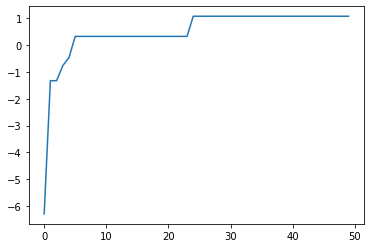

In [69]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(
    np.maximum.accumulate(player.portfolio.batch(by='y').tolist())
)

In [71]:
y.max()

tensor(1.0700, device='cuda:0')

In [86]:
import malt
data = malt.data.collections.linear_alkanes(10)
representation = malt.models.representation.DGLRepresentation(out_features=32)
regressor=malt.models.regressor.NeuralNetworkRegressor(
    in_features=32, out_features=1,
)
likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood()
model = malt.models.supervised_model.SimpleSupervisedModel(
    representation=representation,
    regressor=regressor,
    likelihood=likelihood,
)

mll = malt.models.marginal_likelihood.SimpleMarginalLogLikelihood(
    model.likelihood, model
)

trainer = malt.trainer.get_default_trainer(
    without_player=True,
)
model = trainer(model, data, mll)

In [30]:
# import malt
# data = malt.data.collections.linear_alkanes(10)
# merchant = malt.agents.merchant.DatasetMerchant(data)
# assayer = malt.agents.assayer.DatasetAssayer(data)

# representation = malt.models.representation.DGLRepresentation(out_features=32)
# regressor=malt.models.regressor.NeuralNetworkRegressor(
#     in_features=32, out_features=1,
# )
# likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood()
# model = malt.models.supervised_model.SimpleSupervisedModel(
#     representation=representation,
#     regressor=regressor,
#     likelihood=likelihood,
# )

# mll = malt.models.marginal_likelihood.SimpleMarginalLogLikelihood(
#     model.likelihood, model
# )

# player = malt.agents.player.SequentialModelBasedPlayer(
#     model=model,
#     merchant=merchant,
#     assayer=assayer,
#     marginal_likelihood=mll,
#     policy=malt.policy.Greedy(),
#     trainer=malt.trainer.get_default_trainer(),
# )

# player.step()

In [46]:
import torch
import malt
from malt import Dataset
from malt.metrics.supervised_metrics import MSE, MAPE, RMSE, R2
from malt.metrics.base_metrics import mse, mape, rmse, r2

class DumbModel(object):
    def __init__(self, y):
        self.y = y

    def __call__(self, *args, **kwargs):
        return torch.distributions.Normal(
            self.y.ravel(), 1.0
        )

input_ = torch.randn(5, 1)
target = torch.randn(5, 1)

ds = []
for idx in range(5):
    point = malt.Molecule(smiles="C", metadata={'y': target[idx].item()})
    ds.append(point)

ds = malt.Dataset(ds)

assert MSE()(DumbModel(input_), ds) == mse(input_, target)
assert MAPE()(DumbModel(input_), ds) == mape(input_, target)
assert RMSE()(DumbModel(input_), ds) == rmse(input_, target)
assert R2()(DumbModel(input_), ds) == r2(input_, target)

In [8]:
DumbModel(input_)(g).loc

tensor([-0.4679,  1.2411,  0.5564,  0.1261,  2.0364], device='cuda:0')

In [4]:
g, y = ds.batch(by=['g', 'y'], use_gpu=False)

In [5]:
y

tensor([ 0.8460,  0.0106,  1.3695, -0.0019, -0.4241])

In [61]:
R2()(DumbModel(input_), ds)

tensor(-0.3713, device='cuda:0')

In [62]:
r = R2()

In [1]:
import torch
import malt
from malt.metrics.supervised_metrics import MSE, MAPE, RMSE, R2
from malt.metrics.base_metrics import mse, mape, rmse, r2
input_ = torch.randn(5, 1)
target = torch.randn(5, 1)

ds = []

for idx in range(5):
    point = malt.Molecule(smiles="C", metadata={'y': target[idx].item()})
    ds.append(point)

ds = malt.Dataset(ds)

assert MSE()(DumbModel(input_), ds).item() == mse(input_, target).item()
assert MAPE()(DumbModel(input_), ds).item() == mape(input_, target).item()
assert RMSE()(DumbModel(input_), ds).item() == rmse(input_, target).item()
assert R2()(DumbModel(input_), ds).item() == r2(input_, target).item()

print(
    MSE()(DumbModel(input_), ds).item(),
    mse(input_, target).item()
)
print(
    MAPE()(DumbModel(input_), ds).item(),
    mape(input_, target).item()
)
print(
    RMSE()(DumbModel(input_), ds).item(),
    rmse(input_, target).item()
)
print(
    R2()(DumbModel(input_), ds).item(),
    r2(input_, target).item()
)

Using backend: pytorch


NameError: name 'DumbModel' is not defined

In [181]:
print(
    MSE()(DumbModel(input_), ds).item(),
    mse(input_, target).item()
)


0.9318310618400574 0.9318311810493469
